# Introduction

## Import the Data
The data is 130k wine taste notes, points, price, and bottle details. This data was obtained from **WHERE** and will be explored below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Import and print the data
df = pd.read_csv('winemag-data.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Print the info for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


In [4]:
# What are the total NA values for each column?
df.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## Data Cleaning
The one missing variety will be removed from the data as there will be no affect on the model performance for one less item. The 'Unnamed: 0 column will be dropped as it is just an index. The rest of the values will be left blank **BECAUSE**. 

In [5]:
# Drop the unnamed coumn
df.drop('Unnamed: 0', axis=1, inplace=True)

# Drop missing variety in data
df = df.dropna(subset=['variety']).reset_index()

# 
df['price'] = df['price'].interpolate(limit_direction='both')
df.isna().sum()

index                        0
country                     63
description                  0
designation              37464
points                       0
price                        0
province                    63
region_1                 21246
region_2                 79459
taster_name              26243
taster_twitter_handle    31212
title                        0
variety                      0
winery                       0
dtype: int64

## Data Exploration
Several questions were posed when looking at the dataframe. The following questions were aked and the relationships will be explored below: 
1. What are the largest produced varities? Highest price? highest reviewed?
2. Which countries and regions produce the largest quantities of wine? highest priced? highest reviews?
3. What are the most common descriptor words in the reviews? 
4. Which tasters has reviewed more wine? what is the spread of their reviews?
5. Which winery is considered the best per variety? Is there certain wineries that command a premium price?
6. What years were the majority of the bottles produced? How does bottle year affect the price and points?
7. What is the correlation between the numeric variables?

### Variety
There are a total of 708 unique varieties of wine in the data. Here are the highlights of the variety data exploration below:
    1. The top three most common varities are Pinot Noir, Chardonay, and Cabernet Sauvingnon. These three varieties represent 26.54% of the population. 
    2. Rose on average was the cheapest variety with an average of 18 USD a bottle. This is surprising due to Rose rise in popularity the last few years. 
    3. The varieties that claimed the highest prices (over 1000 USD) was Bordeaux-style Red Blend, Pinot Noir, and Chardonnay. These small handful of bottles are considered outliers when compared to the mean and the standard deviation of their respective varieties. But the **reason for not dealing with price outliers**
    4. In term of points, all the varieties ranged from 80 - 100 points. The only variety that stood out was Rose with a smaller spread and lowest mean at 86 points. This points to a potential correlation between the points a bottle has and the commanding price of the bottle.  

In [6]:
# Create list of unique varieties
# Print the number of unique variables
var_unique = df['variety'].unique()
print('The number of unique varieties is {}.'.format(len(var_unique)))

The number of unique varieties is 707.


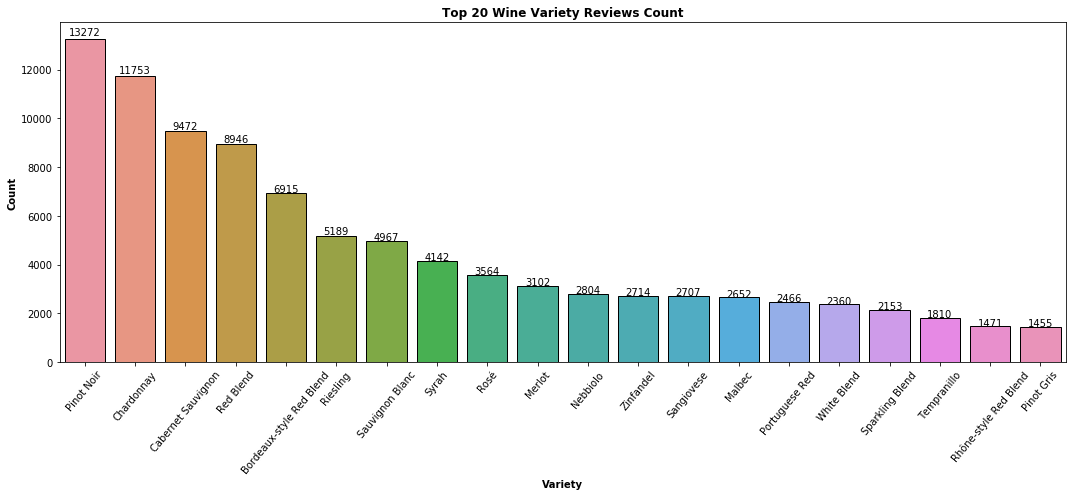

In [7]:
plt.figure(figsize=(15, 7))

# Plot the chart of top 20 varities
graph = sns.countplot(x=df['variety'], 
            order=df['variety'].value_counts().iloc[:20].index,
                     edgecolor='black')

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        df['variety'].value_counts()[i], ha="center")

plt.title('Top 20 Wine Variety Reviews Count', fontweight='bold')
plt.xlabel('Variety', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [8]:
# Calculate the percentage of n from the total population
n = 3
var_counts = df['variety'].value_counts().sum()
top_3 = df['variety'].value_counts().nlargest(n).sum()

percentage = round((top_3/var_counts*100), 2)

print('The top 3 varieties represent {}% of the population'.format(percentage))

The top 3 varieties represent 26.54% of the population


In [9]:
# Create a list with the 20 largest variety opulations
variety_largest = df['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']

# Create dataframe from that list
variety_index = df.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

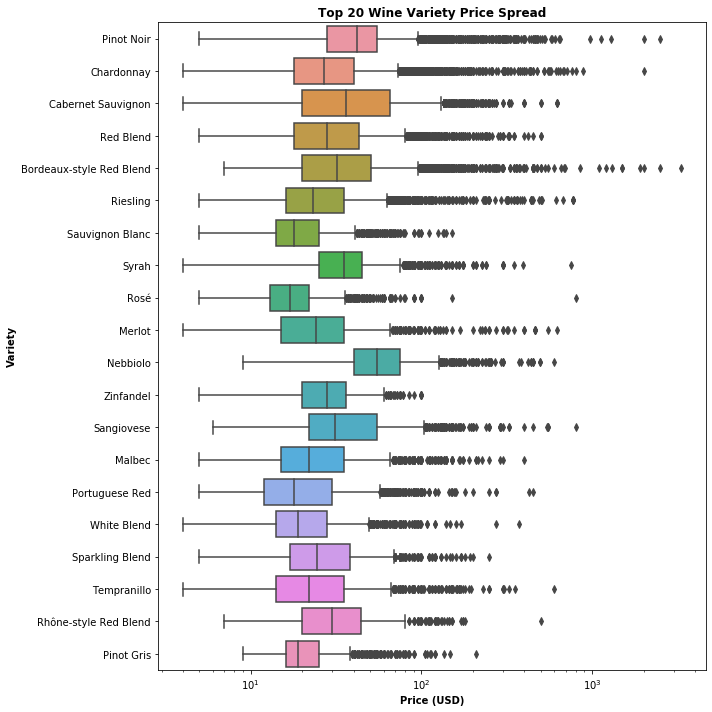

In [10]:
# Plot variety vs price
plt.figure(figsize=(10, 10))
graph = sns.boxplot(x=variety_index['price'], 
               y=variety_index['variety'])

# Log scale transform x axis
graph.figure.get_axes()[0].set_xscale('log')

plt.title('Top 20 Wine Variety Price Spread', fontweight='bold')
plt.ylabel('Variety', fontweight='bold')
plt.xlabel('Price (USD)', fontweight='bold')


plt.tight_layout()
plt.show()

In [11]:
# The variety price statistics
variety_index.groupby('variety')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Bordeaux-style Red Blend,6915.0,46.836659,83.334536,7.0,20.0,32.0,50.477273,3300.0
Cabernet Sauvignon,9472.0,47.829730,41.077454,4.0,20.0,36.0,65.000000,625.0
Chardonnay,11753.0,34.766326,41.497235,4.0,18.0,27.0,40.000000,2013.0
Malbec,2652.0,30.023756,26.587301,5.0,15.0,22.0,35.000000,400.0
Merlot,3102.0,29.576805,33.177356,4.0,15.0,24.0,35.000000,625.0
Nebbiolo,2804.0,62.138612,42.145085,9.0,40.0,55.0,75.000000,595.0
Pinot Gris,1455.0,23.464037,14.832746,9.0,16.0,19.0,25.000000,207.5
Pinot Noir,13272.0,47.553432,48.687207,5.0,28.0,42.0,55.000000,2500.0
Portuguese Red,2466.0,25.597040,25.070974,5.0,12.0,18.0,30.000000,450.0


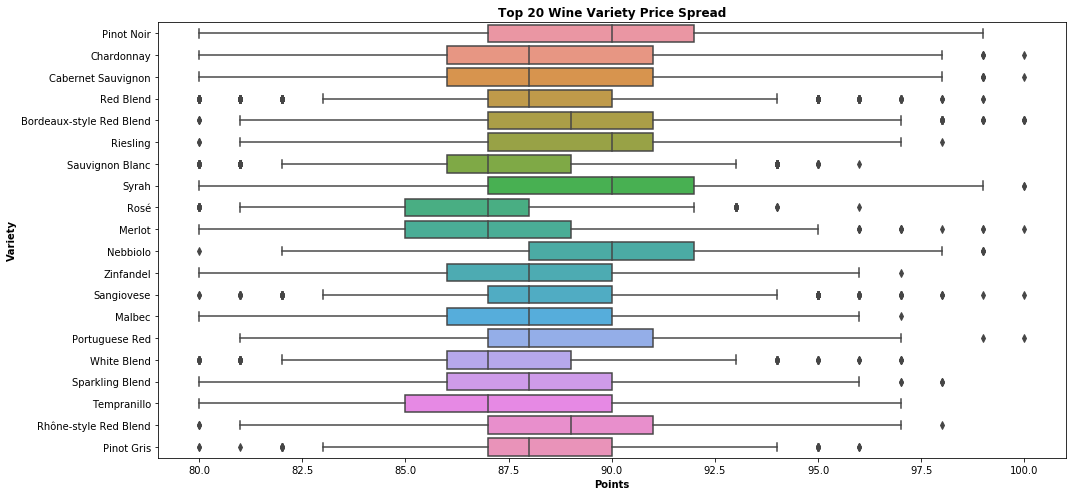

In [12]:
# plot the Variety vs Points Spread
plt.figure(figsize=(15, 7))
sns.boxplot(x=variety_index['points'], y=variety_index['variety'])

plt.title('Top 20 Wine Variety Price Spread', fontweight='bold')
plt.ylabel('Variety', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

In [13]:
# Variety Points statistics
variety_index.groupby('variety')['points'].describe()

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Bordeaux-style Red Blend,6915.0,89.106435,3.136137,80.0,87.0,89.0,91.0,100.0
Cabernet Sauvignon,9472.0,88.607580,3.316328,80.0,86.0,88.0,91.0,100.0
Chardonnay,11753.0,88.340083,3.231557,80.0,86.0,88.0,91.0,100.0
Malbec,2652.0,87.983032,3.102440,80.0,86.0,88.0,90.0,97.0
Merlot,3102.0,87.208575,2.967417,80.0,85.0,87.0,89.0,100.0
Nebbiolo,2804.0,90.251070,2.717213,80.0,88.0,90.0,92.0,99.0
Pinot Gris,1455.0,88.496220,2.631119,80.0,87.0,88.0,90.0,96.0
Pinot Noir,13272.0,89.411468,3.123967,80.0,87.0,90.0,92.0,99.0
Portuguese Red,2466.0,88.810624,2.973620,81.0,87.0,88.0,91.0,100.0


### Countries and Regions
The US, France, and Italy produce 74% of the wine in this dataset. This is unsurprising due to the vast amounts of wineries in these countries. The US produces the most Pinot Noir, Chardonnay, and Cabernet Sauvignon. While France produces the most Bordeaux, which is not surprising. Italy produces mainly Cabernet Sauvignons. 

What was interesting in the data is that the largest producers of wine did not have the highest average prices or points per bottle of wine. France did have the largest deviation with many of its wines fetching the highest prices, but due to the large volume of lower priced bottles the average per variety were lower. 

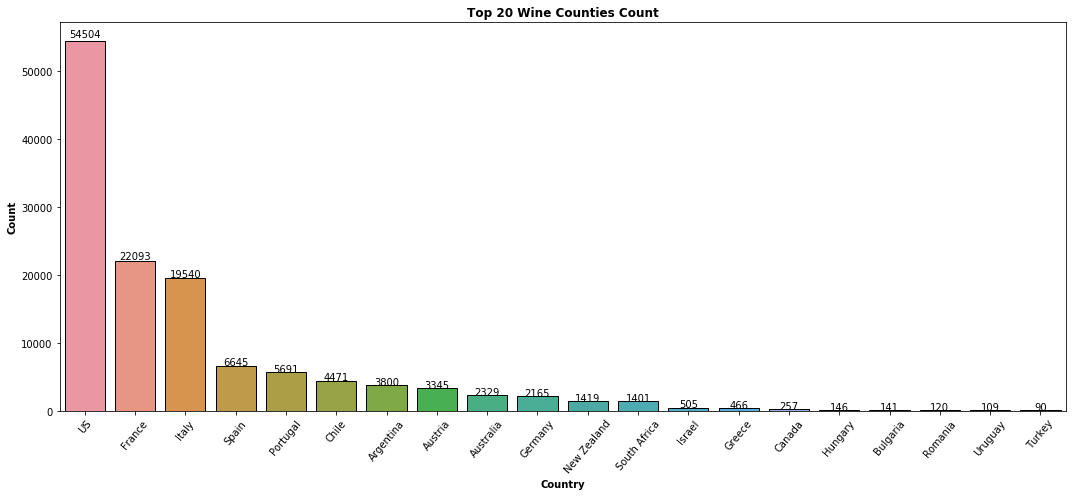

In [14]:
plt.figure(figsize=(15, 7))

# Plot the chart of top 20 varities
graph = sns.countplot(x=df['country'], 
                order=df['country'].value_counts().iloc[:20].index,
                     edgecolor='black')

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        df['country'].value_counts()[i], ha="center")

plt.title('Top 20 Wine Counties Count', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [15]:
# Calculate the percentage of n from the total population
n = 3
var_counts = df['country'].value_counts().sum()
top_3 = df['country'].value_counts().nlargest(n).sum()

percentage = round((top_3/var_counts*100), 2)

print('The top 3 countries represent {}% of the population'.format(percentage))

The top 3 countries represent 74.0% of the population


In [16]:
# Create a list of largest producers of wine
country_largest = df['country'].value_counts().nlargest(n).reset_index()
country_largest = country_largest['index']

# Create a new dataframe from that list
country_index = df.set_index('country')
country_index = country_index.loc[country_largest].reset_index()

# Get list of largest varieties from dataframe
variety_largest = country_index['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']


variety_index = country_index.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

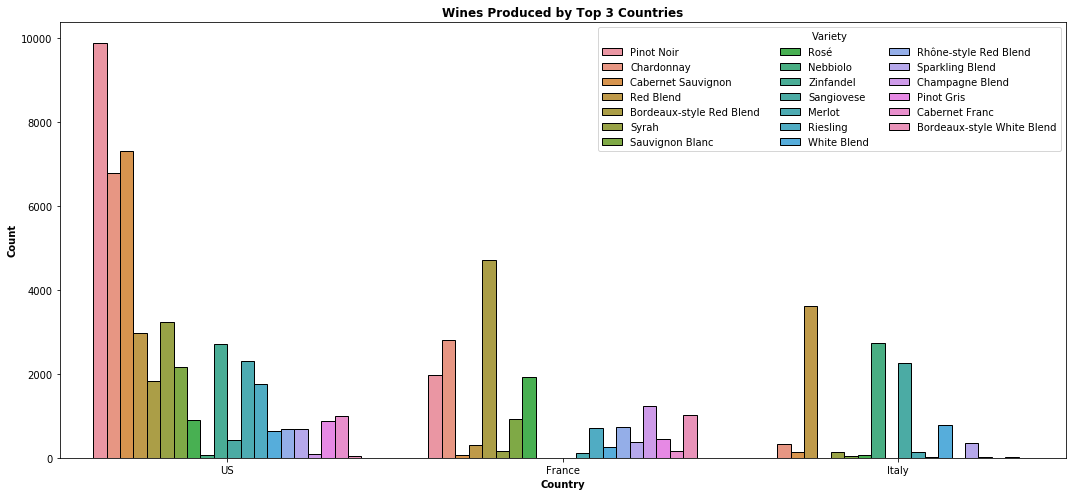

In [17]:
# Plot of the varieties produced by country

plt.figure(figsize=(15, 7))
sns.countplot(x=variety_index['country'], 
           hue=variety_index['variety'], edgecolor='black')

plt.title('Wines Produced by Top 3 Countries', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.legend(title='Variety', ncol=3, loc='upper right')

plt.tight_layout()
plt.show()

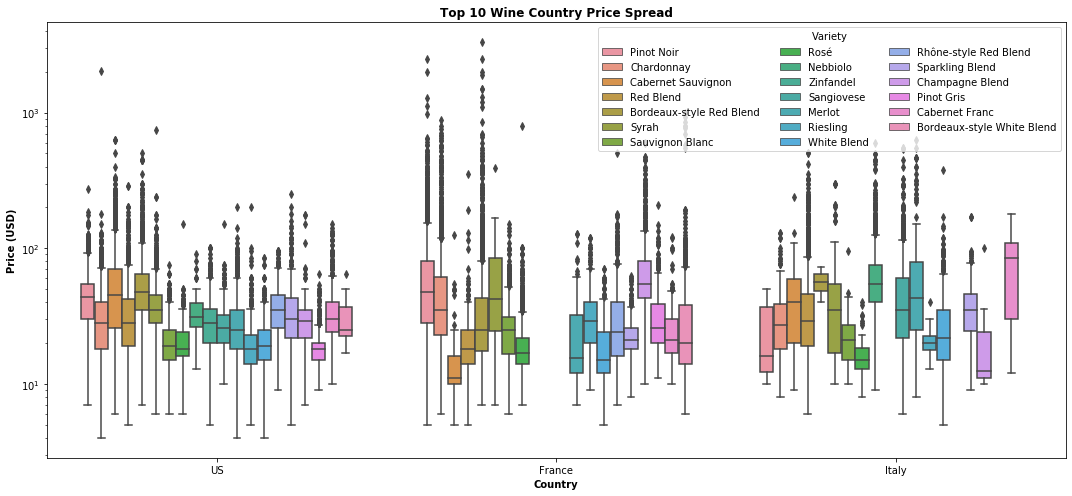

In [18]:
# Plot the Price per Country by Variety
plt.figure(figsize=(15, 7))
graph = sns.boxplot(x=variety_index['country'], y=variety_index['price'], 
                    hue=variety_index['variety'])

plt.title('Top 10 Wine Country Price Spread', fontweight='bold')
plt.ylabel('Price (USD)', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.legend(title='Variety', ncol=3, loc='upper right')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.tight_layout()
plt.show()

In [19]:
# Average prices for 10 highest and lowest
country_avg = df.groupby('country')['price'].mean()
print('Higest Average Bottle Price per Country',country_avg.nlargest(10))
print('\nCheapest Average Bottle Price per Country',country_avg.nsmallest(10))

Higest Average Bottle Price per Country country
Switzerland    85.285714
England        51.168919
Germany        42.154503
France         41.028401
Hungary        40.626712
Italy          38.781537
US             36.550137
Canada         35.517510
Australia      35.310677
Austria        32.323468
Name: price, dtype: float64

Cheapest Average Bottle Price per Country country
Ukraine                    9.214286
Bosnia and Herzegovina    12.500000
India                     13.333333
Armenia                   14.500000
Bulgaria                  14.645390
Romania                   15.241667
Macedonia                 15.583333
Slovakia                  16.000000
Cyprus                    16.272727
Moldova                   16.745763
Name: price, dtype: float64


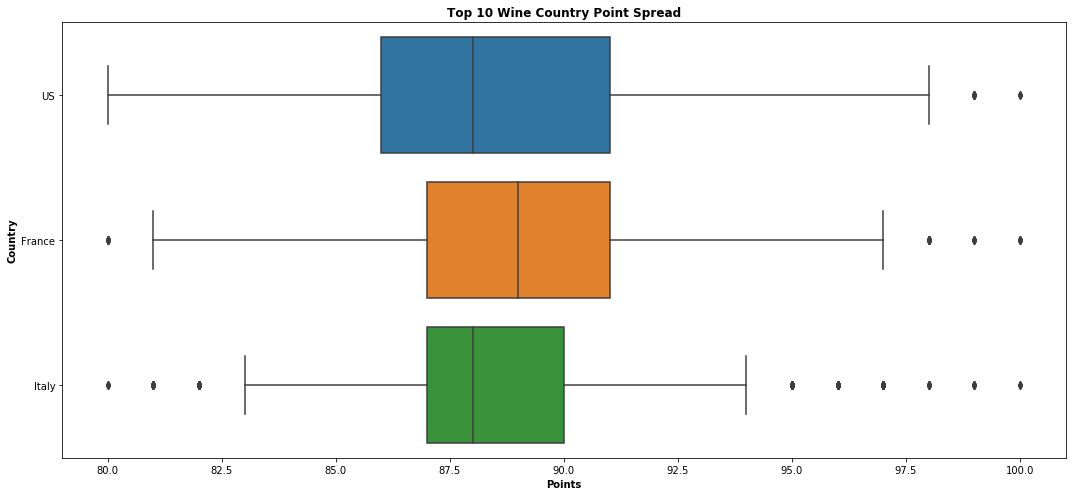

In [20]:
# Plot point Spread per Country by Variety
plt.figure(figsize=(15, 7))
sns.boxplot(x=country_index['points'], y=country_index['country'])

plt.title('Top 10 Wine Country Point Spread', fontweight='bold')
plt.ylabel('Country', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

In [21]:
# Top 10 Countries with highest and lowest points
country_avg = df.groupby('country')['points'].mean()
print('Higest Average Bottle Points per Country',country_avg.nlargest(10))
print('\nLowest Average Bottle Points per Country',country_avg.nsmallest(10))

Higest Average Bottle Points per Country country
England       91.581081
India         90.222222
Austria       90.101345
Germany       89.851732
Canada        89.369650
Hungary       89.191781
China         89.000000
France        88.845109
Luxembourg    88.666667
Australia     88.580507
Name: points, dtype: float64

Lowest Average Bottle Points per Country country
Peru                      83.562500
Egypt                     84.000000
Ukraine                   84.071429
Brazil                    84.673077
Mexico                    85.257143
Romania                   86.400000
Chile                     86.493178
Bosnia and Herzegovina    86.500000
Argentina                 86.710263
Uruguay                   86.752294
Name: points, dtype: float64


### Points
The point distribution below shows an ideal gaussian distribution with the mean being 88.44 points. As pointed out in the variety sections there is a correlation with price vs point. The log scaled chart below shows the positive correlation between the two variables. The lowest point bottles on average sell for 16 USD while a perfect rated bottle sells for 485 USD. Surprisingly the highest priced bottle in the dataset (3300 USD) only scored 88 points. 

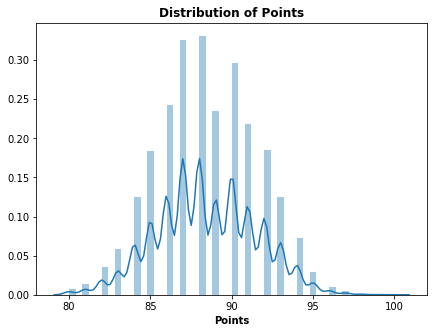

Average Points: 88.44714164807263

Median Point: 88.0


In [22]:
# Plot distribution plot of points
plt.figure(figsize=(7, 5))
sns.distplot(df['points'])

plt.title('Distribution of Points', fontweight='bold')
plt.xlabel('Points', fontweight='bold')

plt.show()

avg_points = df['points'].mean()
med_points = df['points'].median()
print('Average Points: {}'.format(avg_points))
print('\nMedian Point: {}'.format(med_points))

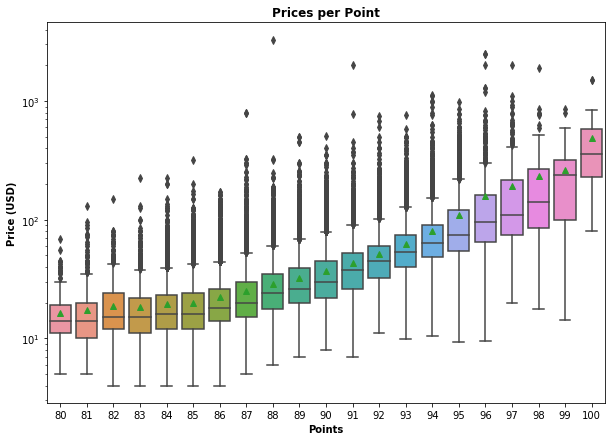

In [23]:
# Plot boxplot of price vs points
plt.figure(figsize=(10, 7))

graph = sns.boxplot(x=df['points'], y=df['price'], showmeans=True)

plt.title('Prices per Point', fontweight='bold')
plt.ylabel('Price (USD)', fontweight='bold')
plt.xlabel('Points', fontweight='bold')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.show() 

In [24]:
# Generate list of average price per point
score_price = df.groupby('points')['price'].mean()
print(score_price.sort_values(ascending=False))

points
100    485.947368
99     261.467424
98     233.577273
97     193.030223
96     158.067566
95     108.517725
94      80.785955
93      62.953872
92      51.035546
91      43.363083
90      36.959824
89      32.259241
88      28.743419
87      24.987180
86      22.202366
85      20.000686
84      19.360801
82      18.857571
83      18.206446
81      17.165462
80      16.346348
Name: price, dtype: float64


# Bottles
The first aspect explored in this section was the how many times on average was a bottle reviewed. Per the data below severa bottles were reviewed multiple times with the highest being 11. A bottle on average was reviewed 1.09 times. Seven out of the ten most expensive bottles were Bordeaux's all in the high 90s point range. All the most expensive bottles except for one was produced in France; the one was produced in the US. In terms of Pinot Noirs, both bottles were produced by the same winery with the more expensive bottle being produced in 2010 vs 2005. 

In [25]:
# Generate list of 10 most reviewed bottles and the counts
df['title'].value_counts().nlargest(10)

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                11
Korbel NV Brut Sparkling (California)                                  9
Segura Viudas NV Extra Dry Sparkling (Cava)                            8
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)                   7
Ruinart NV Brut Rosé  (Champagne)                                      7
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)                7
Pierre Sparr NV Brut Réserve Sparkling (Crémant d'Alsace)              6
J Vineyards & Winery NV Brut Rosé Sparkling (Russian River Valley)     6
Jacquart NV Brut Mosaïque  (Champagne)                                 6
Boizel NV Brut Réserve  (Champagne)                                    6
Name: title, dtype: int64

In [26]:
# Calculate the average reviews per bottle
avg_bottle = df['title'].value_counts().mean()

print('Average Number Reviews per Bottle: {}'.format(
    round(avg_bottle, 2)))

Average Number Reviews per Bottle: 1.09


In [27]:
# Sort dataframe by highest price
top_bottles = df.sort_values(by='price', ascending=False)

# Print 10 highest priced bottles
top_bottles[['title', 'variety', 'winery', 'price', 'points', 'country']].head(10)

,title,variety,winery,price,points,country
80290,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet,3300.0,88,France
15840,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2500.0,96,France
98379,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2500.0,96,France
120390,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,Chardonnay,Blair,2013.0,91,US
65352,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2000.0,97,France
113563,Domaine du Comte Liger-Belair 2005 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2000.0,96,France
1558,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux,1900.0,98,France
111754,Château Cheval Blanc 2010 Saint-Émilion,Bordeaux-style Red Blend,Château Cheval Blanc,1500.0,100,France
111752,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild,1500.0,100,France
1575,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild,1300.0,96,France


## Wineries
The wineries that produced the most wines are located in Protugal, US, France, and Chile. Here are some highlights identified in the charts below:
    1. Louis Latour produces only Chardonnay and Pinot Noir, which commands the highest price out of all the wineries below. While their wines had higher than average point than all the bottles there were many wineries that scored better such as Williams Selyem.
    2. DFJ Vinhos from Portugal had the lowest price of all the wineries, and their bottles were lower than average on points. The data shows a correlation between the diversification of variety and price. I.e. the more varieties a winery produces the lower quality overall and the cheaper the selling price.
    3. The charts below show a huge correlation between the price of the wine and the variety of wine. Pinot Nior and Chardonnay bottles were the highest priced bottles for most of the wineries. 

In [28]:
# Create list of 10 largest wineries
winery_largest = df['winery'].value_counts().nlargest(10).reset_index()
winery_largest = winery_largest['index']

# Create dataframe of 10 largest winereies
winery_index = df.set_index('winery')
winery_index = winery_index.loc[winery_largest].reset_index()

# Get list of largest varieties from dataframe
variety_largest = winery_index['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']


variety_index = winery_index.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

In [29]:
# Count of the number of wineries 
print('Counties with the highe number of wineries: {}'.format(
      winery_index['country'].unique()))

Counties with the highe number of wineries: ['Portugal' 'US' 'France' 'Chile']


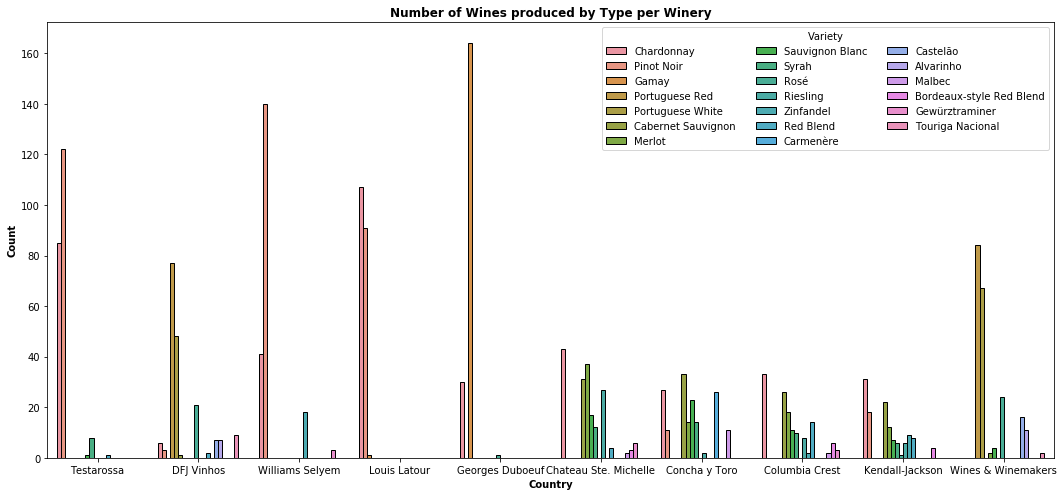

In [30]:
# Plot of the varieties produced by country

plt.figure(figsize=(15, 7))
sns.countplot(x=variety_index['winery'], 
           hue=variety_index['variety'], edgecolor='black')

plt.title('Number of Wines produced by Type per Winery', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.legend(title='Variety', ncol=3, loc='upper right')

plt.tight_layout()
plt.show()

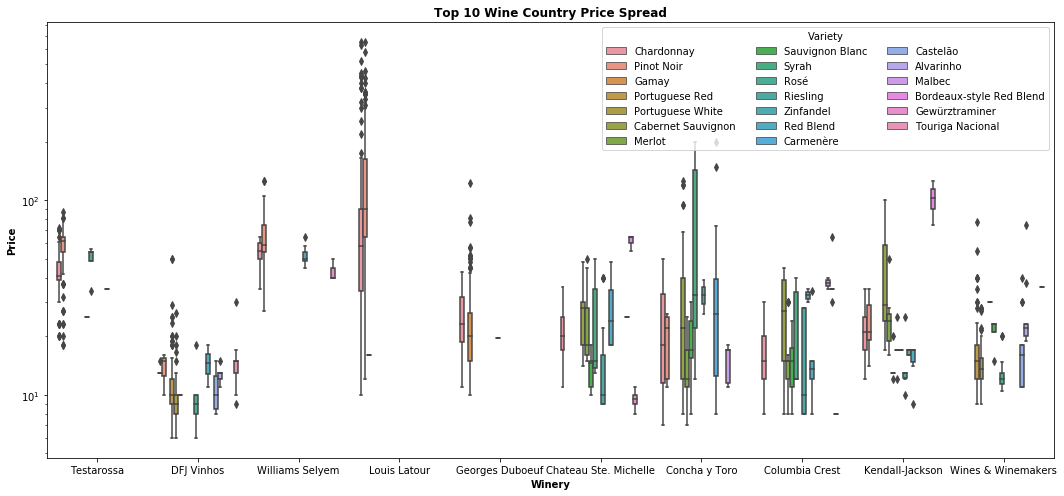

In [31]:
plt.figure(figsize=(15, 7))
graph = sns.boxplot(x=variety_index['winery'], y=variety_index['price'],
                   hue=variety_index['variety'])

plt.title('Top 10 Wine Country Price Spread', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xlabel('Winery', fontweight='bold')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.legend(title='Variety', ncol=3, loc='upper right')
plt.tight_layout()
plt.show()

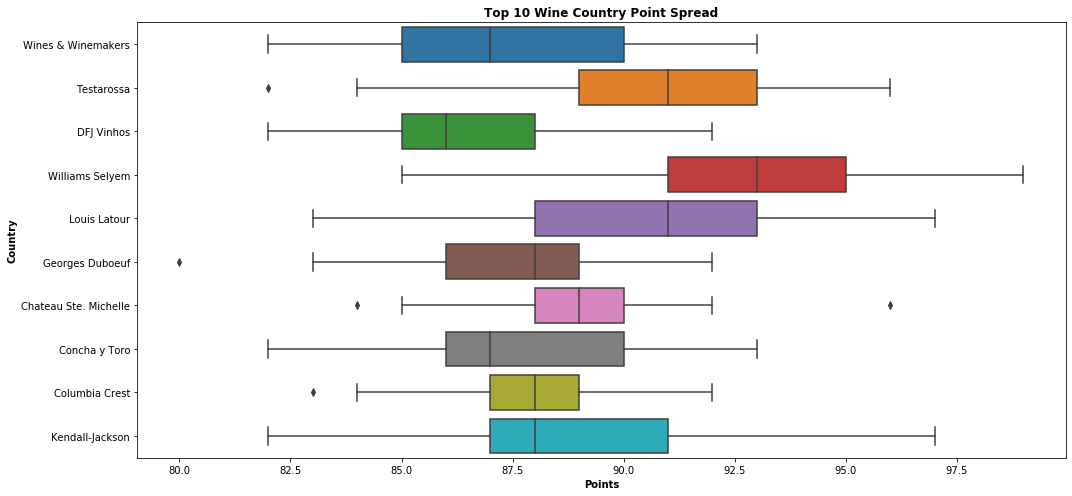

In [32]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=winery_index['points'], y=winery_index['winery'])

plt.title('Top 10 Wine Country Point Spread', fontweight='bold')
plt.ylabel('Country', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

## Tasters
The tasters of the wine in this dataset are identified below. The tasters with the most tasting notes are Roger Voss, Michael Schachner, and Kerin O'Keefe. The tasters with the most reviews had similar point average to the data average. 

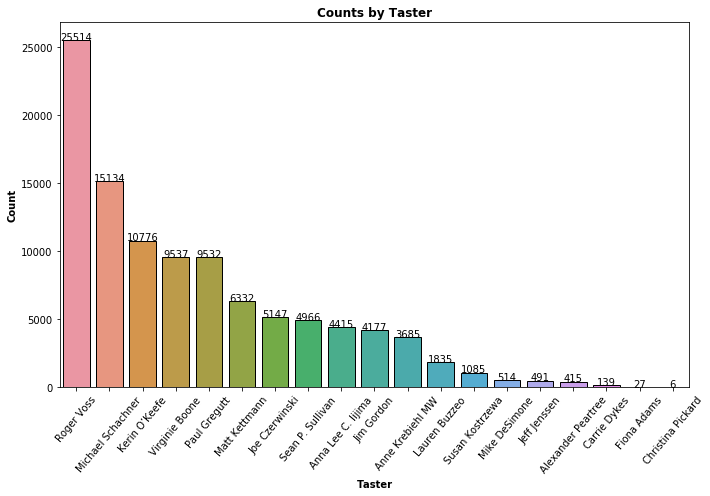

In [33]:
plt.figure(figsize=(10, 7))

# Plot the chart of Tasters
graph = sns.countplot(x=df['taster_name'], 
                      order=df['taster_name'].value_counts().index,
                     edgecolor='black')

# Add count total for each bar
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        df['taster_name'].value_counts()[i],ha="center")
    i += 1

plt.title('Counts by Taster', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [34]:
# Create a list with the 20 largest variety opulations
variety_largest = df['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']

# Create dataframe from that list
variety_index = df.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

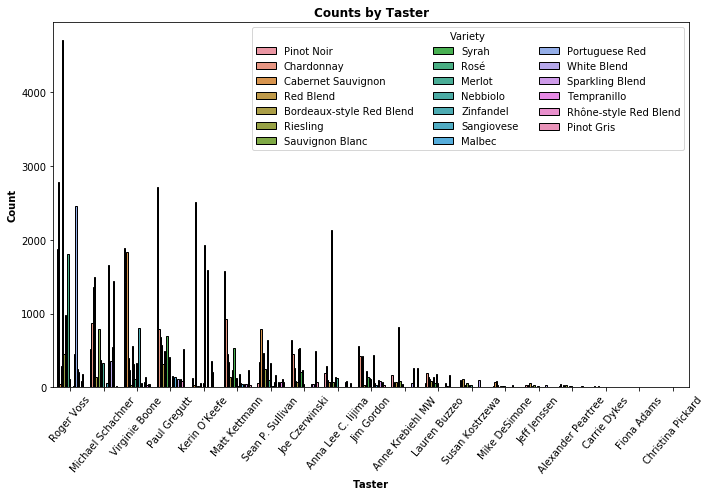

In [35]:
plt.figure(figsize=(10, 7))

# Plot the chart of Tasters and variety counts
graph = sns.countplot(x=variety_index['taster_name'], 
                      order=variety_index['taster_name'].value_counts().index,
                     edgecolor='black', hue=variety_index['variety'])

plt.title('Counts by Taster', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.legend(title='Variety', ncol=3, loc='upper right')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [36]:
# Print points statistics and average points per taster
print(df['points'].describe())
print('\n', df.groupby('taster_name')['points'].mean())

count    129970.000000
mean         88.447142
std           3.039742
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

 taster_name
Alexander Peartree    85.855422
Anna Lee C. Iijima    88.415629
Anne Krebiehl MW      90.562551
Carrie Dykes          86.395683
Christina Pickard     87.833333
Fiona Adams           86.888889
Jeff Jenssen          88.319756
Jim Gordon            88.626287
Joe Czerwinski        88.536235
Kerin O’Keefe         88.867947
Lauren Buzzeo         87.739510
Matt Kettmann         90.008686
Michael Schachner     86.907493
Mike DeSimone         89.101167
Paul Gregutt          89.082564
Roger Voss            88.708003
Sean P. Sullivan      88.755739
Susan Kostrzewa       86.609217
Virginie Boone        89.213379
Name: points, dtype: float64


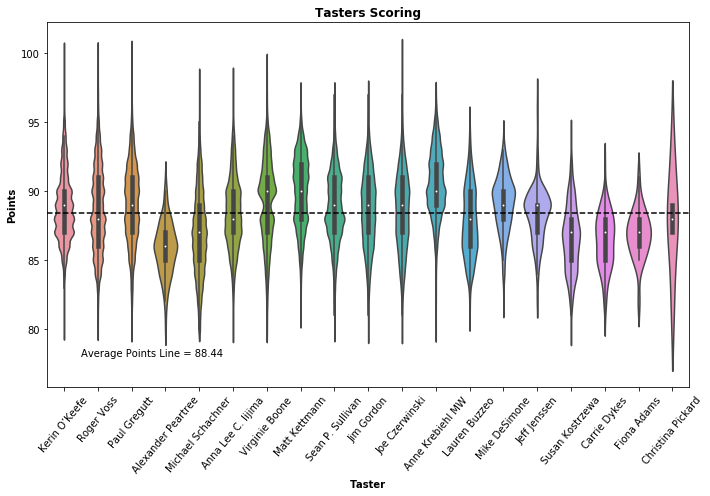

In [37]:
# Plot violin plot of tasters scoring
plt.figure(figsize=(10, 7))

sns.violinplot(x=df['taster_name'], y=df['points'])

# Plot points average line
plt.axhline(df['points'].mean(), color='black', ls='--')
plt.text(0.5,78, 'Average Points Line = 88.44')

plt.title('Tasters Scoring', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Points', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

## Year
From the year data exploration below several key items were learned:
    1. The majority of the bottles were produced in the last 15 years with the mean being 2010.
    2. There is a positive correlation between price and the year of the bottle. The older the bottle the higher average price it commands.
    3. There is no correlation between the age of the bottle and the points assigned to the bottle. 

In [38]:
# Create dataframe column of bottle year based on the title of bottle
df['year'] = df['title'].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

# Keep only first 4 digits of numeric numbers
years = []
for year in df['year']:
    year = ''.join(year[:4])
    years.append(year)

# Convert string to numeric    
df['year'] = years
df['year'] = pd.to_numeric(df['year'], errors='coerce', downcast='integer')

# Set values outside date range to None
mask = df['year'] > 2017
column_name = 'year'
df.loc[mask, column_name] = None

mask = df['year'] < 1990
df.loc[mask, column_name] = None

# Print year stats
df['year'].describe()

count    124403.000000
mean       2010.695441
std           3.547348
min        1990.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: year, dtype: float64

In [39]:
# Sum of NA values
df['year'].isna().sum()

5567

In [40]:
# Fill based on average year
df['year'] = df['year'].fillna(df['year'].mean())
df['year'] = round(df['year'])
df['year'].isna().sum()

0

In [41]:
# Convert year column from float to integer
df['year'] = df['year'].astype(int)

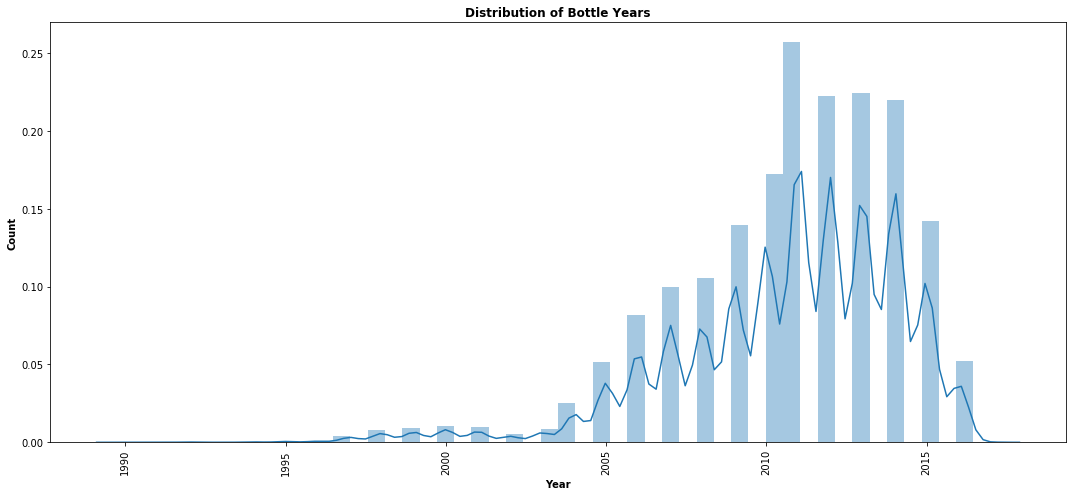

In [42]:
# Plot distribution of bottle years
plt.figure(figsize=(15, 7))

graph = sns.distplot(df['year'])

plt.ylabel('Count', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.title('Distribution of Bottle Years', fontweight='bold')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

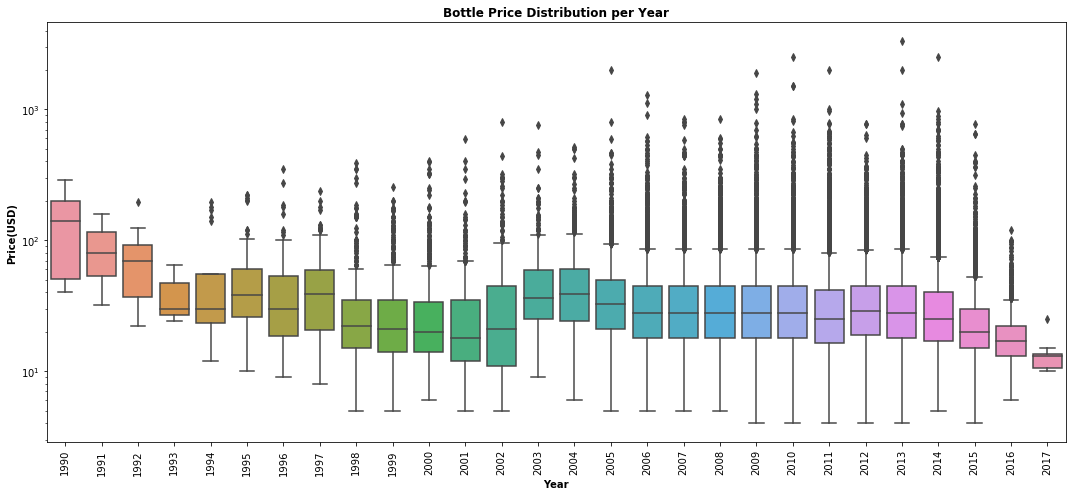

In [43]:
# Plot years vs price
plt.figure(figsize=(15, 7))

graph = sns.boxplot(x=df['year'], y=df['price'])
plt.xticks(rotation=90)

plt.ylabel('Price(USD)', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.title('Bottle Price Distribution per Year', fontweight='bold')

# Log scale transform y axis
graph.figure.get_axes()[0].set_yscale('log')

plt.tight_layout()
plt.show()

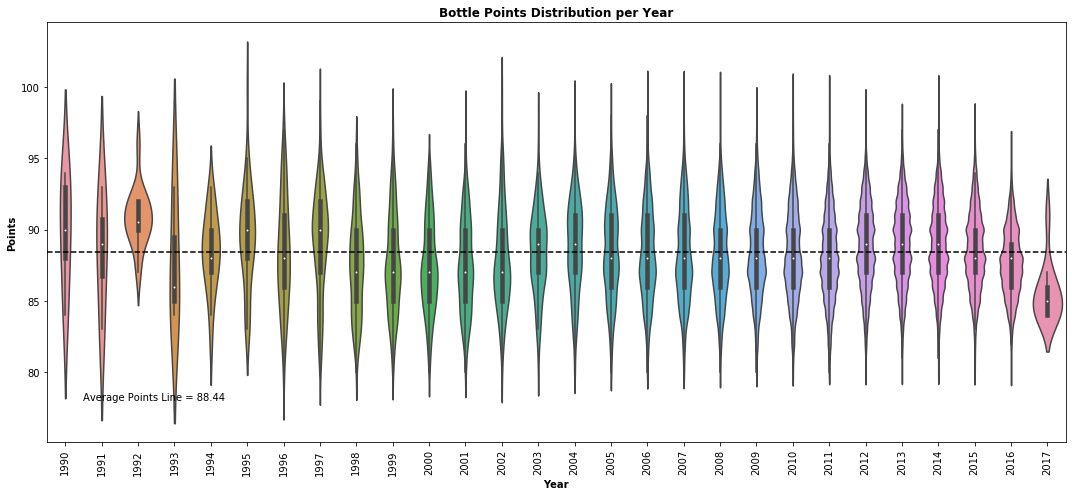

In [44]:
# Plot points per Year
plt.figure(figsize=(15, 7))

sns.violinplot(x=df['year'], y=df['points'])
plt.xticks(rotation=90)

plt.ylabel('Points', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.title('Bottle Points Distribution per Year', fontweight='bold')

# Plot points average line
plt.axhline(df['points'].mean(), color='black', ls='--')
plt.text(0.5,78, 'Average Points Line = 88.44')

plt.tight_layout()
plt.show()

## Correlations
The correlation heatmap below proves key assumptions made above and disproves several. One there is a positive correlation between the price of bottles and the points of the bottle. It also shows that there is no correlation between the  year of the bottle and the points assigned. Surprisingly, there is no correlation between the age of a bottle and the price of the bottle. 

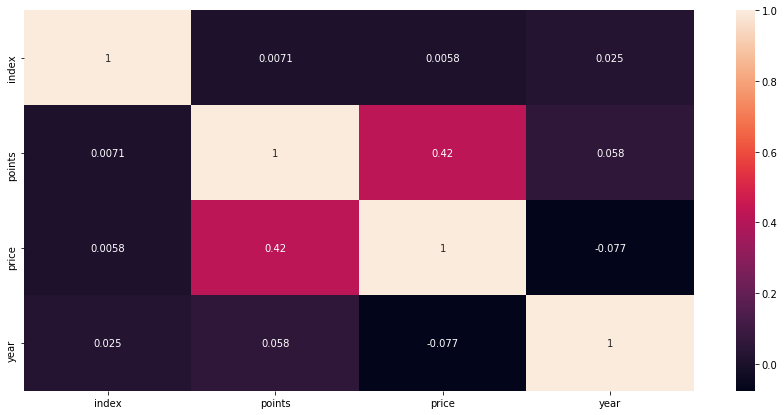

In [45]:
# Create correlation variable
df_corr = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(df_corr, annot=True)
plt.show()

## Description
This section is where things start getting fun. A seen in the word cloud below there are many keywords that could be associated with certain varities of wines. The wine description will be cleaned, and the key words will be extracted below using Count Vectorizer and various functions. See below for details of this exploration.

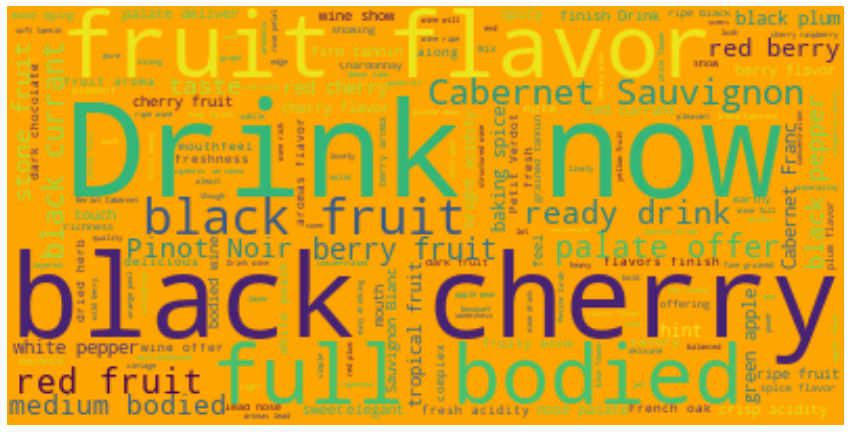

In [46]:
from wordcloud import WordCloud

# Create wordcloud of most used words in description
wordcloud = WordCloud(background_color='orange').generate(
            ''.join(df['description']))

plt.figure(figsize=(15, 10))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [47]:
# Get the word count stats per description
word_count = df['description'].apply(lambda x: len(str(x).split(' ')))
word_count.describe()

count    129970.000000
mean         40.384327
std          11.113570
min           3.000000
25%          33.000000
50%          39.000000
75%          47.000000
max         135.000000
Name: description, dtype: float64

#### Description Cleaning


In [48]:
pd.Series(''.join(df['description']
                 ).split()).value_counts().nlargest(10)


and     346931
of      172822
the     168165
a       157462
with    115570
is       96234
this     72466
in       59654
wine     55983
to       55261
dtype: int64

In [49]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

# Create a list of stop words
stop_words = set(stopwords.words('english'))

In [50]:
def clean_text(words):
    """ Clean up all text
    
    Parameters:
        words(str): The text the needs to be cleaned 
    """

    cleaned_list = []
    
    for i in range(0, word_count.count()):
        #Remove punctuations
        text = re.sub('[^a-zA-Z]', ' ', words[i])
    
        #Convert to lowercase
        text = text.lower()
    
        #remove tags
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
        # remove special characters and digits
        text = re.sub("(\\d|\\W)+"," ",text)
    
        # Convert to list from string
        text = text.split()
    
        # Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        cleaned_list.append(text)
    
    return cleaned_list

df['description'] = clean_text(df['description'])

df['description'].head()

0    aroma include tropical fruit broom brimstone d...
1    ripe fruity wine smooth still structured firm ...
2    tart snappy flavor lime flesh rind dominate gr...
3    pineapple rind lemon pith orange blossom start...
4    much like regular bottling come across rather ...
Name: description, dtype: object

#### Creating Vector of Word Counts

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

# CV 
cv = CountVectorizer(max_df=.8, stop_words=stop_words,
                    max_features=1000, ngram_range=(1, 3))

# Create list of descriptions
corpus = df['description'].tolist()

X = cv.fit_transform(corpus)

list(cv.vocabulary_.keys())[:10]

['aroma',
 'include',
 'tropical',
 'fruit',
 'dried',
 'herb',
 'palate',
 'offering',
 'apple',
 'citrus']

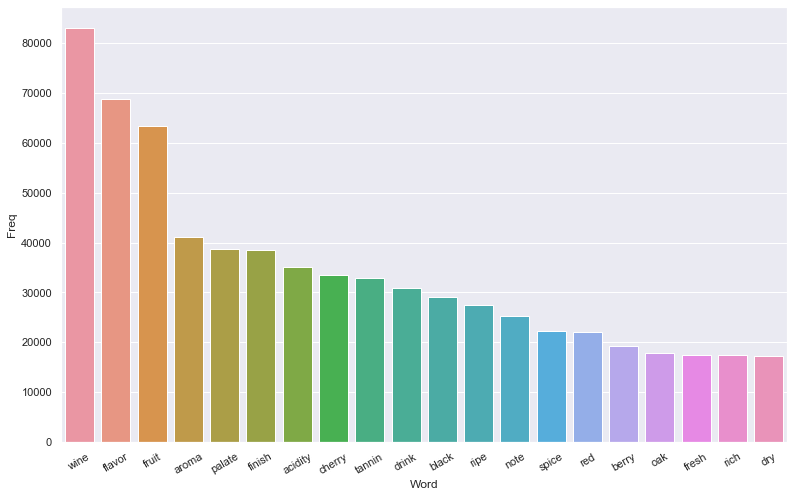

In [52]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words


sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

               Bi-gram  Freq
0         black cherry  8861
1         fruit flavor  7982
2          full bodied  6932
3          black fruit  5608
4   cabernet sauvignon  5259
5            red fruit  4656
6          ready drink  4308
7         palate offer  4256
8        black currant  3778
9          berry fruit  3763
10           red berry  3599
11       medium bodied  3399
12          pinot noir  3221
13          red cherry  2932
14        black pepper  2878
15         stone fruit  2641
16        white pepper  2591
17         green apple  2573
18      tropical fruit  2513
19          black plum  2474


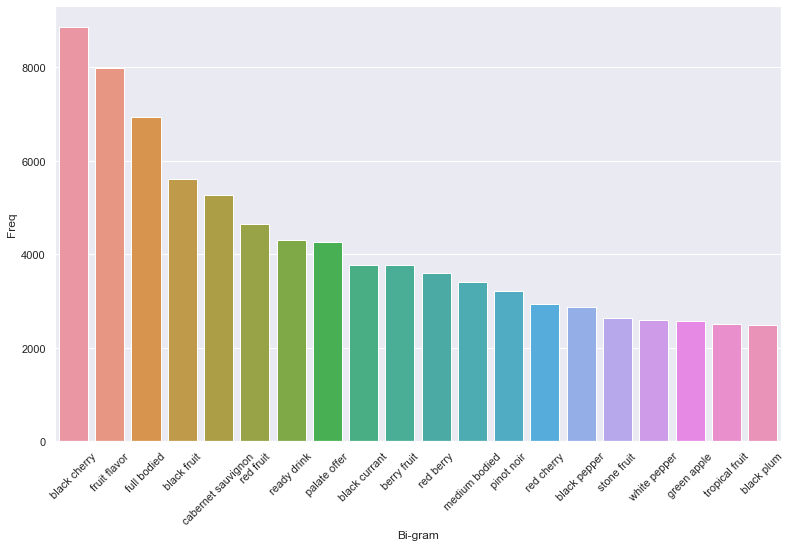

In [53]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.show()

                       Tri-gram  Freq
0           fine grained tannin  1126
1      blend cabernet sauvignon  1116
2              full bodied wine  1110
3     cabernet sauvignon merlot  1020
4              wine ready drink   983
5               red berry fruit   932
6            black fruit flavor   883
7                new french oak   801
8            dried black cherry   717
9            medium bodied wine   708
10    merlot cabernet sauvignon   662
11          black currant fruit   662
12            ripe black cherry   634
13           black cherry fruit   625
14             red fruit flavor   622
15        merlot cabernet franc   574
16           palate offer dried   528
17     blackberry black currant   524
18  cabernet sauvignon cabernet   470
19           full bodied palate   470


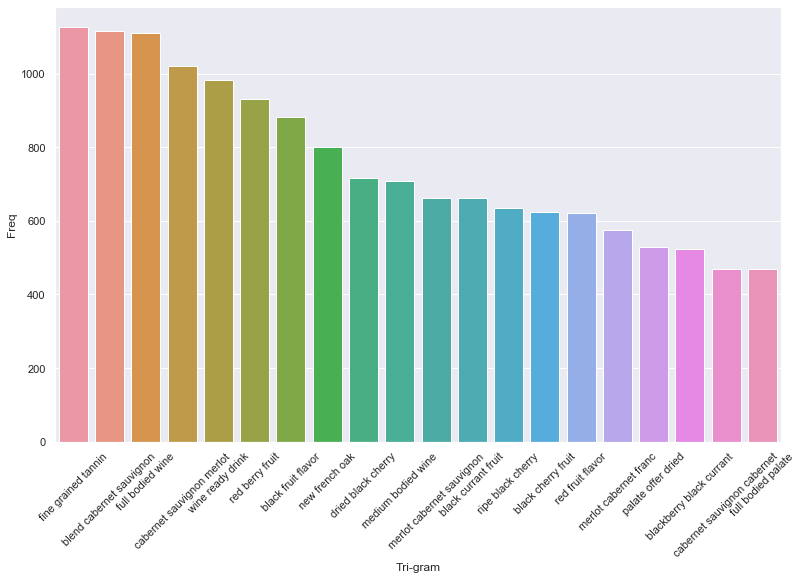

In [54]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)
plt.show()

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[1]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [56]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
ripe fruity wine smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better

Keywords:
drinkable 0.295
certainly 0.294
red berry fruit 0.292
better 0.266
fruity wine 0.257


In [57]:
print(keywords)

{'drinkable': 0.295, 'certainly': 0.294, 'red berry fruit': 0.292, 'better': 0.266, 'fruity wine': 0.257}


In [58]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names

feature_names=cv.get_feature_names()
 


In [59]:
# fetch document for which keywords needs to be extracted
def keyword_gen(description):
    keyword_list = {}
    
    for words in description:
        # fetch document for which keywords needs to be extracted
        doc = words
 
        #generate tf-idf for the given document
        tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
         
        #sort the tf-idf vectors by descending order of scores
        sorted_items = sort_coo(tf_idf_vector.tocoo())
        #extract only the top n; n here is 10
        keywords = extract_topn_from_vector(feature_names,sorted_items,5)
        
        keyword_list.update(keywords)
        
    keyword_list = list(keyword_list.keys())
    temp_list = []
    
    for word in keyword_list:
        if word not in temp_list:
            temp_list.append(word)
    
    column_names = list(df.columns)
    
    temp_list = [x for x in temp_list if x not in column_names]
    
    print('There are {} keywords.'.format(len(temp_list)))
    return temp_list

In [60]:
keywords = keyword_gen(corpus)

There are 996 keywords.


In [61]:
def keyword_dummies(reviews):
    """Iterate through reviews and create dummies"""
    for key in keywords:
        df[str(key)] = reviews.str.contains(
            str(key), case=False)
    
    # Assign 1 for True, 0 for False
    df.iloc[:, 14:] *= 1

In [62]:
import time
start_time = time.time()

keyword_dummies(df['description'])
print("\n--- %s seconds ---" % (time.time() - start_time))  


--- 358.6106147766113 seconds ---


# Model 1: KNN


In [63]:
# Get dummies for country, region, taster, and winery
objects = ['country', 'province', 'region_1', 'region_2', 'taster_name', 'winery']
df_model = pd.concat([df, pd.get_dummies(df[objects], drop_first=True)], axis=1)

from sklearn.preprocessing import normalize

# Normalize the price points and year columns
norm = ['price', 'points', 'year']

df_model[norm] = normalize(df_model[norm])
df_model.head()

,index,country,description,designation,points,price,province,region_1,region_2,taster_name,...,winery_Écluse,winery_Élevée Winegrowers,winery_Éric & Jöel Durand,winery_Ïl Macchione,winery_Ñandú,winery_Órale,winery_Öko,winery_Ökonomierat Rebholz,winery_àMaurice,winery_Štoka
0,0,Italy,aroma include tropical fruit broom brimstone d...,Vulkà Bianco,0.043178,0.007444,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,...,0,0,0,0,0,0,0,0,0,0
1,1,Portugal,ripe fruity wine smooth still structured firm ...,Avidagos,0.043220,0.007452,Douro,NaN,NaN,Roger Voss,...,0,0,0,0,0,0,0,0,0,0
2,2,US,tart snappy flavor lime flesh rind dominate gr...,NaN,0.043178,0.006948,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,...,0,0,0,0,0,0,0,0,0,0
3,3,US,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,0.043178,0.006452,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,...,0,0,0,0,0,0,0,0,0,0
4,4,US,much like regular bottling come across rather ...,Vintner's Reserve Wild Child Block,0.043178,0.032259,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# Y is the target variable
Y = df['variety']

# X is the features
X = df_model.select_dtypes(exclude ='object') 

from sklearn.decomposition import PCA

# Transpose X
#Xt = X.T
#Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
#eig_val, eig_vec = np.linalg.eig(Cx)

# Return number of components above 1
#components = 0
#for x in eig_val:
#    if x > 1:
#        components += 1

#print('Number of Components: {}'.format(components))

# All components above 1 selected for PCA
sklearn_pca = PCA(n_components=components)
X = sklearn_pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_.sum())

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Create trainging and test sets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1, random_state=1)

neighbors = KNeighborsClassifier(n_neighbors=10, weights='distance')

pred_train = neighbors.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

print('Cross Validation of Training Set: \n')
cross_val_score(neighbors, x_train, y_train, cv=5)
print('Cross Validation of Test Set: \n')
cross_val_score(neighbors, x_test, y_test, cv=5)

print('Accuracy Score of Training Set: {}\n'.format(accuracy_score(Y_train, pred_train)))
print('Accuracy Score of Test Set: {}'.format(accuracy_score(Y_test, pred_test)))

MemoryError: 

In [ ]:
print(column_names)

In [ ]:
from platform import python_version

print(python_version())

In [ ]:
 import sys
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)